In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

In [2]:
# This function displays the images
def display(images, flag=0):
    fig = plt.figure(figsize=(25, 25))
    i = 0
    for img in images:
        i += 1
        fig.add_subplot(5,5,i)
        if(flag == 1):
            plt.imshow(img,cmap = "gray")
        else:
            plt.imshow(img)
    plt.show()
    

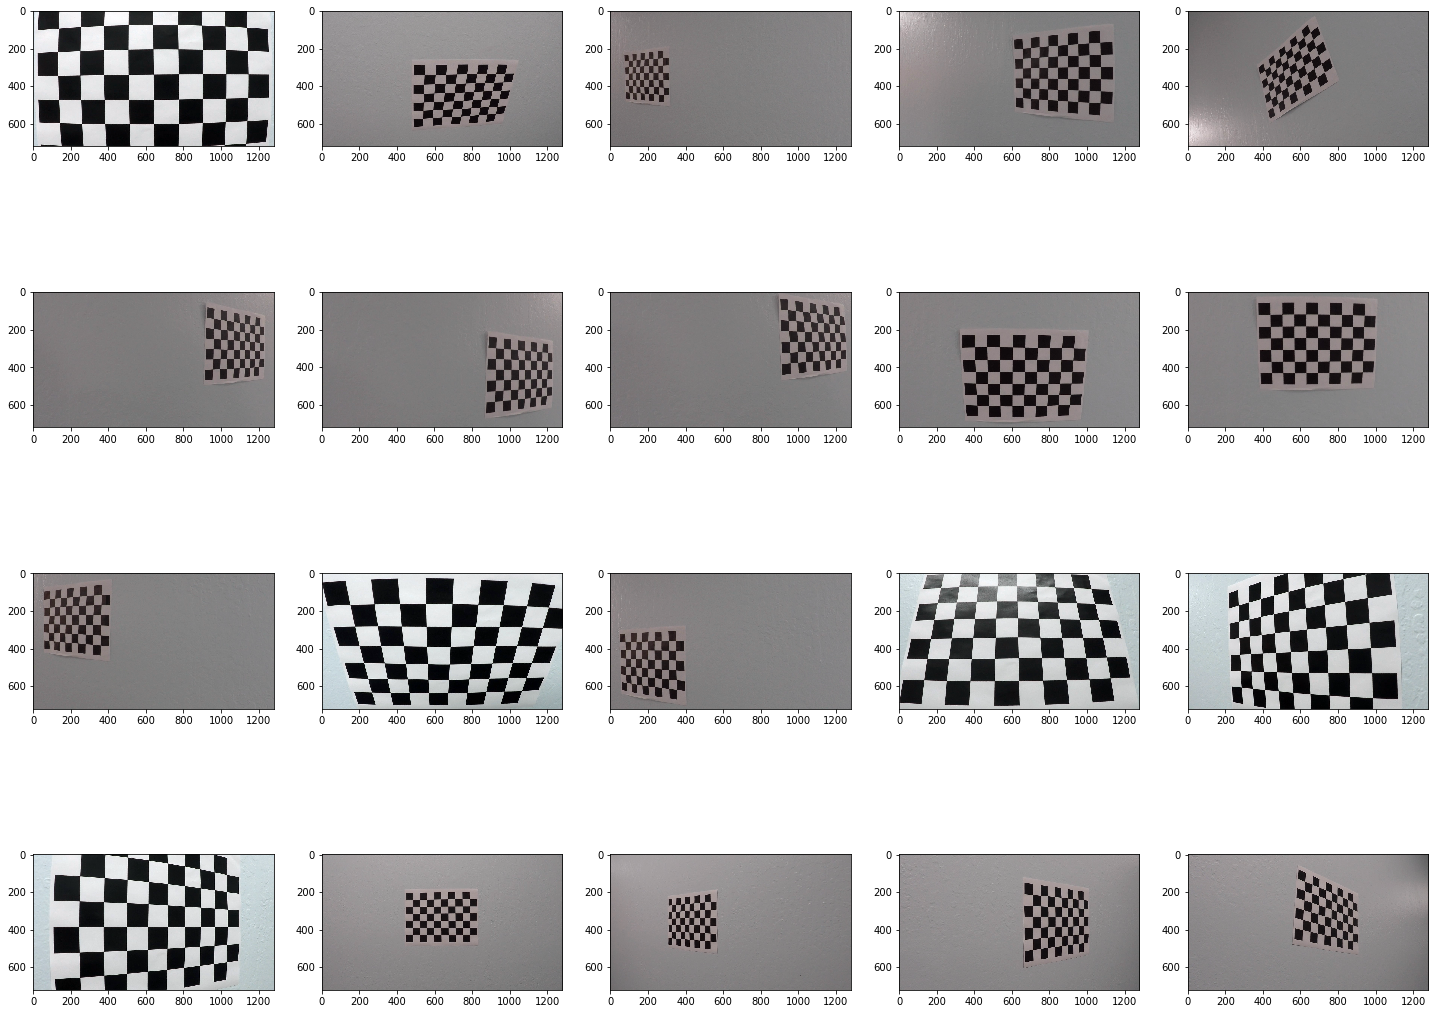

In [3]:
# Reading calibration images
images = [cv2.imread(image) for image in glob.glob("camera_cal/calibration*.jpg")]
display(images)
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)

objpoints = []
imgpoints = []

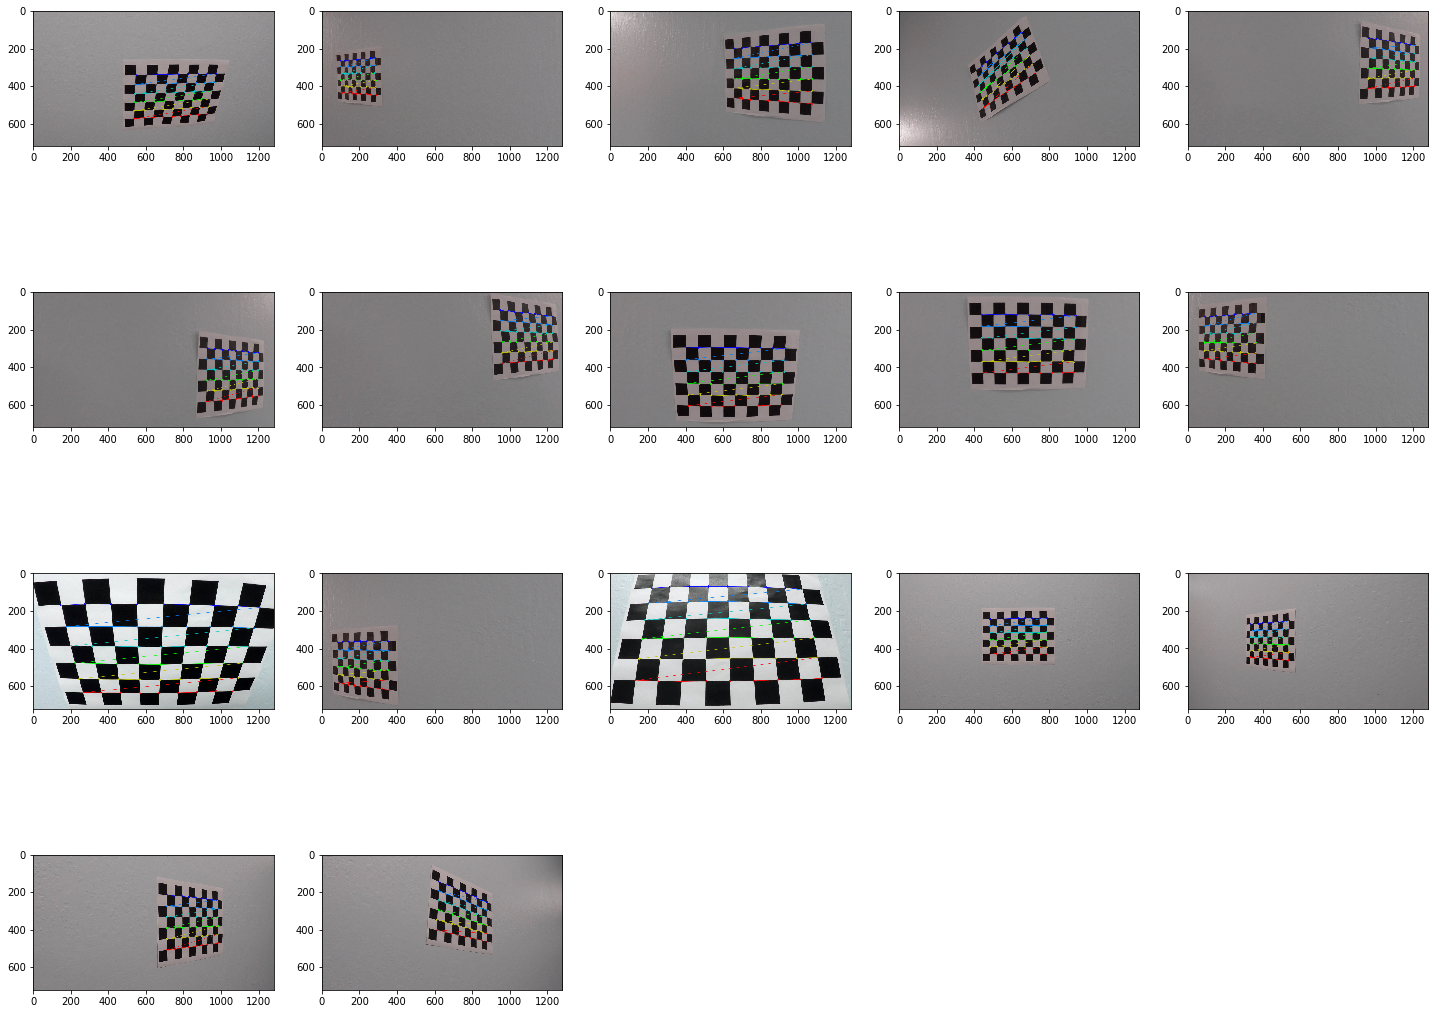

In [4]:
#Declaring neccesary variables
nx = 9
ny = 6
i=0
src = []
chessboard=[]

# Draw Chessboard corners
for img in images:
    #gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(img, (nx, ny),None)
    if ret ==  True:
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        chessboard.append(img)
        imgpoints.append(corners)
        objpoints.append(objp)

display(chessboard)

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

* I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

* I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test images using the `cv2.undistort()`.

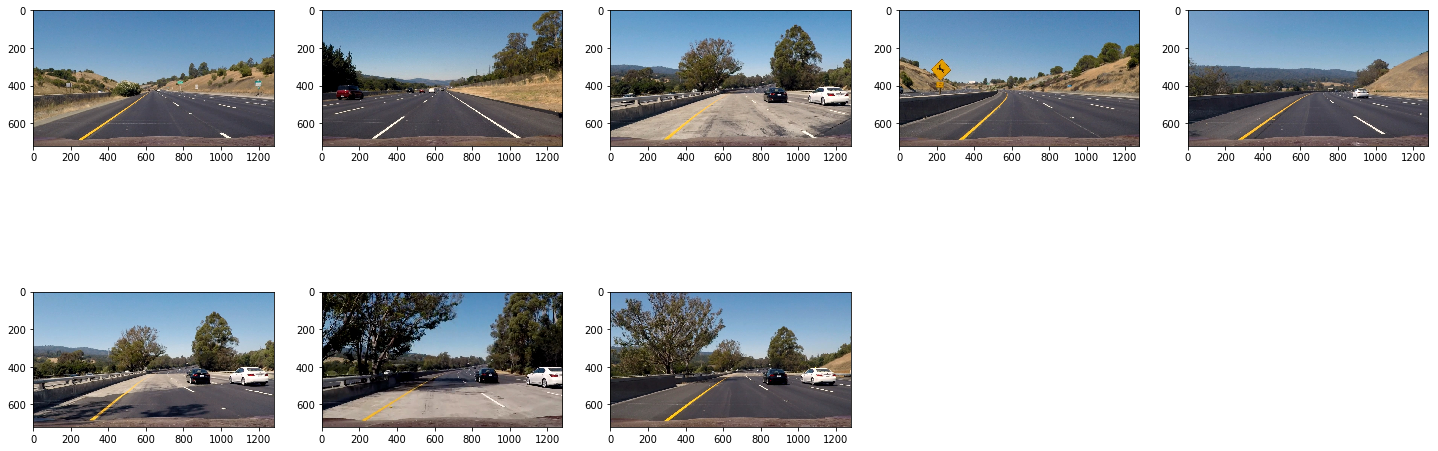

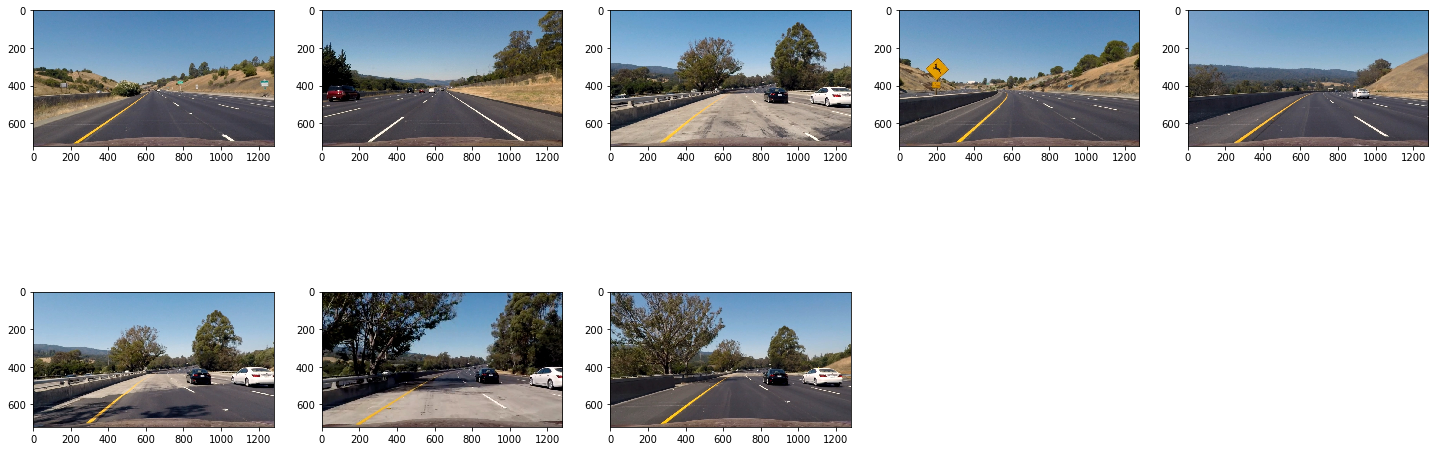

In [18]:
# Reading track images
track_images = [cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB) for image in glob.glob("test_images/*.jpg")]
# Use cv2.calibrateCamera() and cv2.undistort()
track_images_undist = []
def cal_calibrate(img):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #print("inside calibrate")
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst
#plt.imshow(dst)

for img in track_images:
    track_images_undist.append(cal_calibrate(img))

display(track_images)
display(track_images_undist)

In [6]:
# Compute threshold X and color gradient and combine them
def color_gradient(img, sat_thresh=(170, 255), sobel_thresh=(20, 100)):
    #img = np.copy(img)
    
    # print("inside color gradient")
    # Convert to HLS channel to use S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    #print(l_channel)
    
    # Sobel X
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    scaled_sobel = np.uint8(255*np.absolute(sobelx)/np.max(np.absolute(sobelx)))
    
    # Threshold X gradient
    sobelx_binary = np.zeros_like(scaled_sobel)
    sobelx_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Threshold color channel
    sat_binary = np.zeros_like(s_channel)
    sat_binary[(s_channel >= sat_thresh[0]) & (s_channel <= sat_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 100) & (l_channel <= 255)] = 1
    
    #print(l_channel)
    #Combine both binary threshold
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[((sat_binary == 1) & (l_binary == 1))  | (sobelx_binary == 1)] = 1

    return combined_binary

In [7]:
# This function transforms the images according to the perspective
def perspective_transform(img):
    
    #cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    img_size = (img.shape[1], img.shape[0])
   # src = np.float32([[725,470],[1058,668] , [259,668],[555,470]])
    #offset = 50
    
   # dst = np.float32([[950,226], [950,720],[230,720],[230,226]])
    src = np.float32(    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],    [((img_size[0] / 6) - 10), img_size[1]],    [(img_size[0] * 5 / 6) + 60, img_size[1]],    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]]) 
    dst = np.float32(    [[(img_size[0] / 4), 0],    [(img_size[0] / 4), img_size[1]],    [(img_size[0] * 3 / 4), img_size[1]],    [(img_size[0] * 3 / 4), 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)

    return warped, M, M_inv
   

In [8]:
# Finding lane lines in the image
def finding_lines(binary_warped,original_image, inverse_M):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    # print("inside finding lines")
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    '''
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    result = draw_lane(original_image, binary_warped, left_fit, right_fit, inverse_M)
     # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #print(ploty.shape[0], leftx.shape[0])
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    #print(left_fit_cr," SPACE ",right_fit_cr)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    radius=(left_curverad+right_curverad)/2
    
    #find vehicle positioning
    middle = (left_fitx[-1] + right_fitx[-1])//2
    veh_pos = result.shape[1]//2
    dpx = (veh_pos - middle)*xm_per_pix
    #print("vehicle position is ",dx)
    # Example values: 632.1 m    626.2 m
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Radius of curvature  = %.2f m'%(radius),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle position : %.2f m %s of center'%(abs(dpx), 'left' if dpx < 0 else 'right'),(50,110),font, 1,(255,255,255),2,cv2.LINE_AA)
    
    return result, left_fit, right_fit

In [9]:
# Finding lane lines in the image from the previously detected points
def continuing_lines(binary_warped, left_fit, right_fit, original_image, inverse_M):
        # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    result = draw_lane(original_image, binary_warped, left_fit, right_fit, inverse_M)
     # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    #print(left_fit_cr," SPACE ",right_fit_cr)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    radius=(left_curverad+right_curverad)/2
    
    #find vehicle positioning
    middle = (left_fitx[-1] + right_fitx[-1])//2
    veh_pos = result.shape[1]//2
    dpx = (veh_pos - middle)*xm_per_pix
    #print("vehicle position is ",dx)
    # Example values: 632.1 m    626.2 m
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Radius of curvature  = %.2f m'%(radius),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle position : %.2f m %s of center'%(abs(dpx), 'left' if dpx < 0 else 'right'),(50,110),font, 1,(255,255,255),2,cv2.LINE_AA)
    return result, left_fit, right_fit

In [11]:
# Drawing green patch on lane lines
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
   # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
   
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h))
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.


* I calculated the camera calibration through few sample chess board images and I processed the test_images with this camera calibration value to undistort the image.


#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I created a method color_gradient() for combining color and gradient thresholds image to generate a binary image.
Steps I followed are as follows:
* I converted the undistorted image to HLS Color channel and generated an image for S channel and L channel.
* Then I converted the undistorted image to Gray scale for calculating sobelX.
* I selected only those pixel which were in between the set threshold limit.
* Then I combined Saturated channel image, Light channel image and X gradient image.
* Based on above operations i got thresholded binary image.



#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

* The code for my perspective transform includes a function called `perspective_transform()`.  The `perspective_transform()` function takes as inputs an image (`combined_binary`) obtained from `color_gradient()`.
* I chose the source and destination points in the following manner:
```python
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
                      [((img_size[0] / 6) - 10), img_size[1]],
                      [(img_size[0] * 5 / 6) + 60, img_size[1]],
                      [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
         
    dst = np.float32([[(img_size[0] / 4), 0],
                      [(img_size[0] / 4), img_size[1]],
                      [(img_size[0] * 3 / 4), img_size[1]],
                      [(img_size[0] * 3 / 4), 0]])

```

* This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585,460       | 320,0         | 
| 203,720       | 320,720       |
| 1127,720      | 960,720       |
| 695,460       | 960,0         |

* I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.




#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

* Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:
 My code includes a function called `finding_lines()`.
 I drew a histogram to detect the peaks to identify the left and the right lanes, this help me in finding the starting   points of the lanes then i used the sliding window to detect the complete lane, starting from the initial lane point.

* After getting the lines in one frame, rather than refinding the lines from the scratch, i used a function  `continuing_lines()` to detect the lane lines from the previous left and right lane pixels.



#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

* I did this in my code with functions called `finding_lines()` and `continuing_lines()`.
* I calculated the f(y) value for both left lane and right lane.
* Then I converted x,y from pixels space to meters.

* To find the vehicle position from center, I calculated the middle position of the image and then the mid point of the lane.
* Then i used the formula as follows:
                               dpx = (veh_pos - middle)*xm_per_pix
                        If deviation came negative that means car is in right of center.
                        If deviation came positive that means car is in left of center.
                        


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

* Images can be found here: output/images

In [16]:
# Global variables
left_fit=[]
right_fit = []

# Process pipeline
def pipeline(img, index=1):
    global left_fit, right_fit, ploty, leftx, rightx
    undist_img = cal_calibrate(img)
    combined_threshold_img = color_gradient(undist_img)
    unwarped, perspective_M, inverse_M = perspective_transform(combined_threshold_img)
    if(index == 0):
        result, left_fit, right_fit = finding_lines(unwarped, img, inverse_M)
    else:
        result, left_fit, right_fit = continuing_lines(unwarped, left_fit, right_fit, img, inverse_M)
    #visualize(unwarped)
    #print(ploty.shape[0], leftx.shape[0])
    #result = curvature(out_img, left_fit, right_fit, ploty, leftx, rightx)
    
    #result = draw_lane(img, unwarped, left_fit, right_fit, inverse_M)
    display([img,undist_img, combined_threshold_img, unwarped, result ], 1)
    return result
    #return left_fit, right_fit, ploty

720 31570


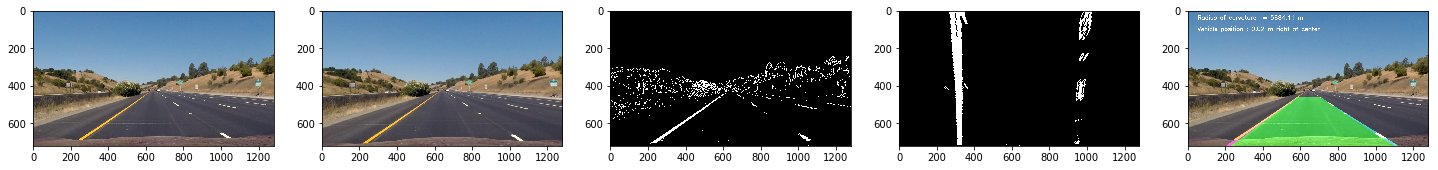

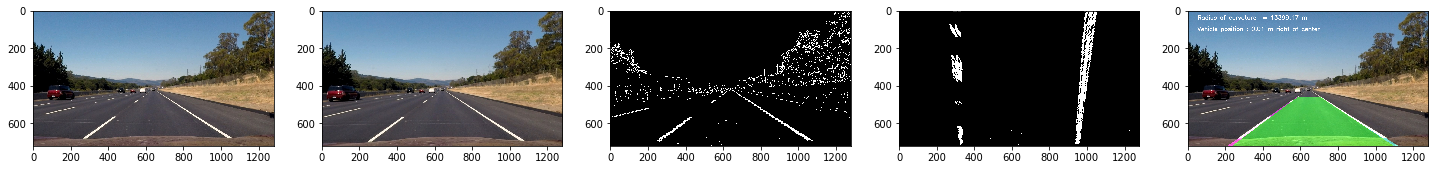

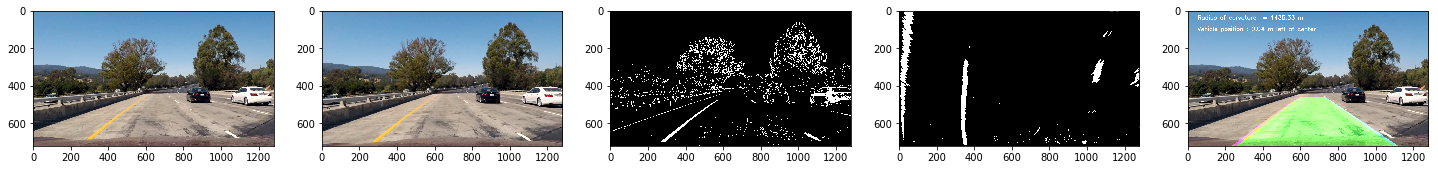

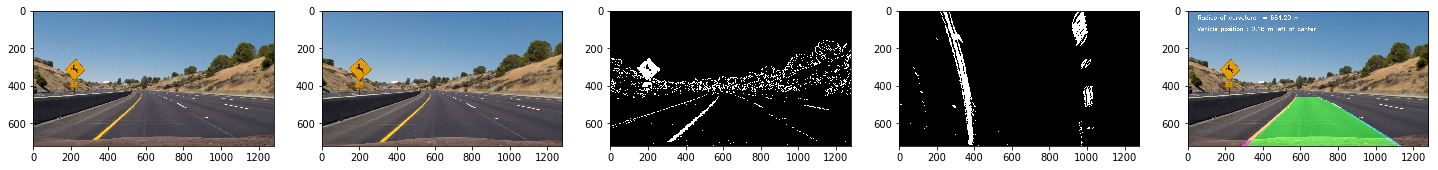

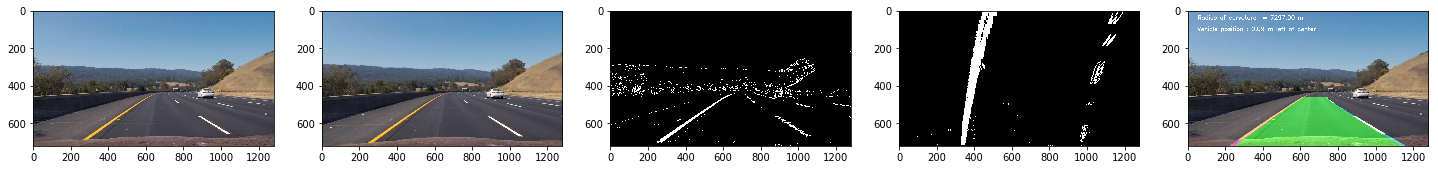

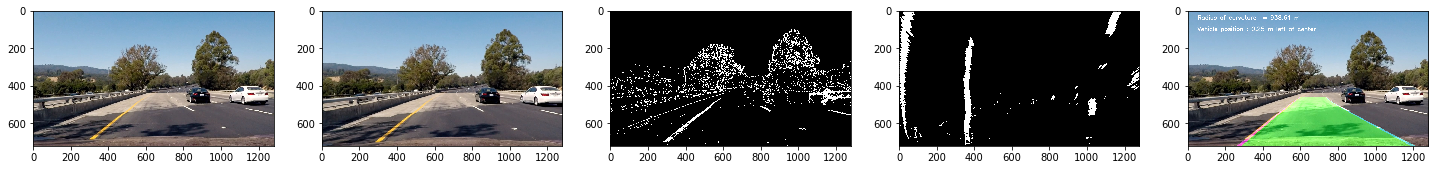

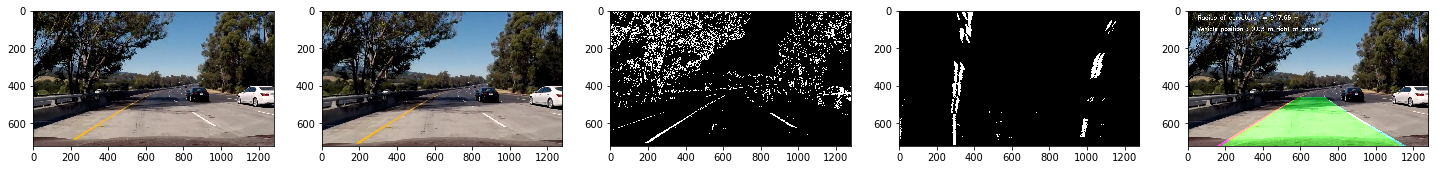

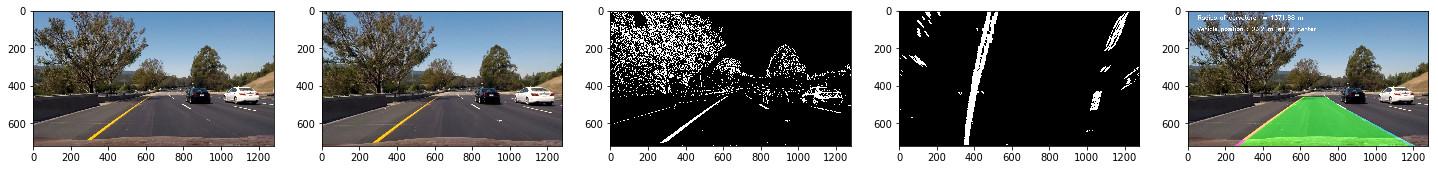

In [17]:
i=0
# Printing images
for img in track_images:
    pipeline(img,i)
    i += 1
   

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./test_video_output/projectFinal_video.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  

1) I saw the line flicker a bit near the trees or shadows, I will try to use different channel and try to reduce the noise.

2) Region masking and gaussian smoothening can be used to get the region of our intrest so that the line can be plotted accurately. Gonna try that too. :)


In [14]:
# Video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

set_prev = 0
do_diagnosis = 0

project_output = 'output/project_video_output4.mp4'
clip1 = VideoFileClip("project_video.mp4");
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False);

[MoviePy] >>>> Building video output/project_video_output4.mp4
[MoviePy] Writing video output/project_video_output4.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [15:51<00:00,  1.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video_output4.mp4 

Wall time: 15min 53s
